# <center>Characterization of pilot-based distributed executions on the<br>XSEDE OSG Virtual Cluster</center>

## Abstract

## Introduction

XSEDE offers resources to support diverse types of computing: high performance, data intense, cloud, and grid. Users can execute their domain-specific applications on any of these resources, depending on application requirements. A growing number of scientific applications executes workflows that can benefit from different computing capabilities, depending on whether their execution requires single and multiple cores; small and large amount of data; or communication and coordination before, during and after runtime. The efficiency of the execution of these workflows can be improved by performing it concurrently and across multiple machines, possibly supporting diverse computing models~\cite{}. This is particularly relevant when considering workflows that have multiple stages, possibly organized in concurrent pipelines, may use asynchronous communication and coordination, while requiring both multi and single-core executions. Paradigmatic examples of these workflows are those used to simulate and analyze the dynamic properties of molecular interactions (MD workflows)~\cite{} or those used to \ldots \mtnote{Make this more general adding examples}~\cite{}.

The time to completion (TTC) of workflows with heterogeneous tasks can be improved by concurrent executions across diverse types of resources. Each type of resources can better serve subsets of the workflow's tasks by offering specific capabilities, software environment, or distinct utilization patterns. Executions performed on a single machine or multiple machines with the same capabilities cannot benefit from these specificities, resulting in a less efficient overall execution. Nonetheless, concurrent executions across diverse types of resources present both conceptual and technological challenges. They require: (i) understanding how the capabilities of specific architectures and software environments can satisfy the heterogeneous set of requirements of workflow's tasks; and (ii) abstracting differences among resources to enable interoperability and coordination across the distributed execution process. Further, Specific technologies have to be implemented to evaluate the workflow requirements, acquire suitable resources, and plan, enact and manage its distributed execution. 

In this paper, we contribute to address these challenges by studying how resource dynamism and heterogeneity affects the TTC of workflows. Specifically, we perform experiments on the XSEDE OSG Virtual Cluster (XOVC) by performing distributed and concurrent execution of a representative set of tasks of a real-life MD workflow. The resources of the XOVC are dynamic because they can shrink and expand depending on load, and because the availability of the resources is not guaranteed over time. Resources can be available or unavailable depending on resource-defined policies, load, or fault. Further, resources are assumed to have heterogeneous architecture, geographical location, and software environment. The XOVC resources can: (i) have different CPU, memory, storage or networking architectures; (ii) have single or clustered components; (iii) be grouped into a lab, data center or dislocated across campus locations; (iv) offer direct access to the operating system, use queues of a batch system, or mono- and multi-tenant resource containers and overlays.

The execution model of applications on XOVC is assumed to take into account both resource dynamisms and heterogeneities. This is supported with both policies and software tools: applications are assumed not to require more than one core per task and it is suggested to limit the runtime of each task to twelve hours~\cite{}. Task execution can be suspended or terminated at any point in time so task checkpointing or, more commonly~\cite{}, rescheduling is assumed. More in general, a certain amount of execution failure is not excluded, due to unassured resource availability but also incompatible execution environment. The heterogeneity of software stack on the pool resources implies non uniform availability of compilers, library, or executables. Applications are therefore assumed to take care of setting up a suitable execution environment.

We focus on use cases that may benefit from distributed and concurrent execution across diverse types of resources. We use a pilot-enabled, interoperable and integrated middleware, supporting a uniform execution model not only on the OSG resources made available by XSEDE but also on its HPC and cloud resources. Thanks to this middleware, pilots can be instantiated, for example, on XOVC, Stampede, Maverick and Bridges and the tasks of a given workflow can be concurrently executed across all the pilots as soon as they become available. The middleware alongside the its benefits and trade offs are described in Ref~\cite{}. Here we note that tasks can be executed sequentially on each pilot as long as that pilot is available and that multiple pilots can be used for concurrent executions. We can submit multiple jobs to XOVC and, once active, each job can bootstrap a pilot agent on which our application can concurrently schedule as many tasks for execution as cores are available to each agent. On OSG, each pilot has one core, so we execute as many tasks as pilots are available.

For our analysis we emulated the concurrent execution of a set of tasks, i.e., a 'workload'. Each task of the workload emulates a specific execution of AMBER, a software package that simulates force fields for the dynamics of biomolecules. We measured the parameters of our emulation by profiling the execution of an AMBER simulation that is part of a real-life use case, investigating novel computational methods to sample relevant regions on the potential energy surface of macromolecular systems. These methods benefit from increasingly large workloads in which each task is performed on a single core: the larger the workload, the longer and more accurate the simulation of the molecular dynamic. Distributing the execution of this type of workload across multiple resources represent a viable path to scalability that does not rely on the availability of increasingly large single-clustered machines but makes use of the increasingly large number of resources already deployed.

In this context, a characterization of XOVC enables understanding the trade offs of distributing the execution of the given workload over available XSEDE resources to improve the TTC of the considered use case. For our characterization, we use the AIMES integrated middleware, a software system we developed to support both experimental and production distributed executions over multiple and diverse resources. The AIMES middleware is designed and implemented as a set of independent software components that can be used both individually or as an integrated system. Once integrated, the AIMES middleware enables the specification of a workload, the use of a profile-based executable emulator, the derivation of an execution strategy for the execution of the specified workload on a set of available resources, and the enactment of this strategy via a pilot system called RADICAL-Pilot and a resource-level interoperability API called RADICAL-SAGA.

We performed 9 distinct experiments with 360 independent workload executions across 13 months, for a total of 262208 single-core emulations successfully executed on XOVC. Our analysis showed: \ldots~\mtnote{summary of contributions.}

This paper has five sections:\ldots~\mtnote{Brief summary of the sections of the paper.}

## Related Work

* What is campus bridging and what is XSEDE doing about it?
* XSEDE campus bridging use cases
* Comparing Futuregrid, amazon ec2, and open science grid for scientific workflows
* Job and data clustering for aggregate use of multiple production cyberinfrastructures
* A Comparison of a Campus Cluster and Open Science Grid Platforms for Protein-Guided Assembly using Pegasus Workflow Management System
* Leveraging the national cyberinfrastructure for biomedical research
* Distributed application runtime environment (DARE): a standards-based middleware framework for science-gateways

## Tools and Methods

* AIMES integrated middleware
* RADICAL-Pilot
* Synapse

We developed RADICAL-Pilot by defining an explicit event and state model. Events can be defined for each software component and states are events guaranteed to be ordered on a sequence. An exception is thrown if two states are not in the predefined order, halting the RADICAL-Pilot execution. Thanks to this approach, we were able to isolate and measure the overhead imposed on our 

## Experiments Design

XOVC resources are dynamic and heterogeneous by design: resource availability is not guaranteed by a service level agreement and their capabilities are not assumed to be homogeneous. Resources are not specifically architected to serve XOVC use cases and are not exclusively dedicated to XVOC. They are utilized by a selected group of users and are opportunistically shared with XSEDE users via XOVC only when underutilized. The same applies to resource capabilities: resources have diverse CPU architectures, networking bandwidth and latency, and local or networked storage facilities. It is important to note that this design choice is not mandated by the utilized technologies: The Condor framework does not mandate opportunistic computing, it enables it when it is chosen as the resource provisioning model.

The opportunistic provision of XVOC resources and their assumed heterogeneity introduces uncertainty in distributed execution of workloads. The concurrency of the distributed execution and the duration of each task are unpredictable due to undefined resource availability and heterogeneity. Policies constrain this uncertainty by limiting the type of tasks that should be submitted to XOVC and keeping a total average of 1000 cores available at any point in time. Consistently, XSEDE users are invited to run single-threaded executables that use less than 2GB of memory and run for up to 12 hours. These policies contribute to constrain uncertainty but do not characterize it: the concurrency of distributed executions of tasks consistent with the indicated parameters and the distribution of the duration of these tasks remain indeterminate. 

We designed nine experiments (Table~\ref{table:experiments}) to characterize how the heterogeneity and dynamism of XVOC relate to the time taken to execute a set of tasks within the boundaries set by XOVC policies. Experimental data enables to understand the trade offs between the number of requested resources, the number of obtained resources, and the time taken to execute the tasks of the workload on those resources. For each experiment we fixed the number of flops required by each task to a constant number. This enabled us to study the distribution of time taken to execute task with the same compute requirements across heterogeneous resources as the result of the heterogeneity of the resources used for the execution. We measured the number of flops of our tasks by profiling an AMBER MD simulation as parametrized by our target use case, and we emulated the computation of those flops via Synapse. In this way, the results of our experiments can be directly correlated to the use case. 

We measured the dynamism of XOVC resources by setting 2 independent variables for each experiment:

* number of tasks of the workload; 
* number of pilots we request to execute them;

and measuring 14 dependent variables: 

* Total time to completion of the workload ($TTC$);
* Total time spent by the pilots waiting in the XVOC queue ($TTQ$);
* Total time spent executing tasks ($TTX$);
* Time spent by a pilot waiting in the XVOC queue ($T_q$);
* Time pent by a task executing ($T_x$);
* number of pilots that become active;
* number of pilots that failed;
* hosts on which pilots become active;
* hosts on which pilots failed;
* number of tasks executed;
* number of tasks failed;
* number of tasks rescheduled;
* number of tasks executed per pilot;
* number of tasks executed per host.

We executed between 8 and 2048 tasks requesting between 8 and 2048 pilots. Each pilot corresponds to a single-core job submitted to XOVC. Once scheduled, the job bootstraps a pilot agent that, once active, pulls tasks from the pilot agent of the user's workstation. Tasks require to download the Synapse executable that in turns requires a python interpreter and a C compiler to execute. When successfully compiled, Synapse emulates the AMBER execution until the configured amount of FLOPS has been consumed. Upon termination of all the tasks of the workload, the execution session is closed and the timestamps of all the relevant events recorded for pilots and tasks are downloaded for 'postmortem' analysis. 

Our experimental design assumes: no resource overcommitment and no input/output file staging. We do not request more pilots than tasks we have to execute. While requesting more pilots may ...


| Experiment | <center>#CU</center>                                            | #Pilots | #Repetitions |
|:----------:|----------------------------------------------------------------:|---------|--------------|
| 1          | 8,16,32,64,128,<span style="color:red">256,512,1024,2048</span> | 8       | 8/8          |
| 2          |   16,32,64,128,256,512,<span style="color:red">1024,2048</span> | 16      | 4/8          |
| 3          |      32,64,128,256,512,<span style="color:orange">1024,2048</span> | 32      | 4/8          |
| 4          |         64,128,256,512,1024,2048                                | 64      | 4/8          |
| 5          |            128,256,512,1024,2048                                | 128     | 4/8          |
| 6          |                256,512,1024,2048                                | 256     | 4/8          |
| 7          |                    512,1024,2048                                | 512     | 4/8          |
| 8          |                        1024,2048                                | 1024    | 4/8          |
| 9          |                             2048                                | 2048    | 4/8          |
[Table 1. Summary of the experiment independent variables. Red numbers of CU indicates that no data has been yet collected for those variables; orange that an experiment is undergoing to collect data. Number of repetitions indicates how many times an experiment has been repeated and how many times will have to be repeated.]

## Results and Discussion

\mtnote{Description}

Load python modules and some helper functions.

In [21]:
%matplotlib inline

import numpy as np
import scipy as sp
import pandas as pd
import scipy.stats as sps
import statsmodels.api as sm

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import matplotlib.ticker as ticker
import matplotlib.gridspec as gridspec

import radical.utils as ru
import radical.pilot as rp
import radical.analytics as ra

from IPython.display import display
from scipy.stats import linregress

pd.set_option('expand_frame_repr', False)
pd.set_option('display.max_rows', 50)

In [2]:
# Global configurations
# ---------------------

# Use LaTeX and its body font for the diagrams' text.
mpl.rcParams['text.usetex'] = True 
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif']  = ['Nimbus Roman Becker No9L']

# Font sizes
SIZE = 12
plt.rc('font', size=SIZE)  # controls default text sizes
plt.rc('axes', titlesize=SIZE)  # fontsize of the axes title
plt.rc('axes', labelsize=SIZE)  # fontsize of the x any y labels
plt.rc('xtick', labelsize=SIZE)  # fontsize of the tick labels
plt.rc('ytick', labelsize=SIZE)  # fontsize of the tick labels
plt.rc('legend', fontsize=SIZE-2)  # legend fontsize
plt.rc('figure', titlesize=SIZE)  # # size of the figure title

# Use thinner lines for axes to avoid distractions.
mpl.rcParams['axes.linewidth']    = 0.75
mpl.rcParams['xtick.major.width'] = 0.75
mpl.rcParams['xtick.minor.width'] = 0.75
mpl.rcParams['ytick.major.width'] = 0.75
mpl.rcParams['ytick.minor.width'] = 0.75

# Do not use a box for the legend to avoid distractions.
mpl.rcParams['legend.frameon'] = False

# Helpers
# -------

# Use coordinated colors. These are the "Tableau 20" colors as 
# RGB. Each pair is strong/light. For a theory of color    
tableau20 = [(31 , 119, 180), (174, 199, 232), # blue        [ 0,1 ]
             (255, 127, 14 ), (255, 187, 120), # orange      [ 2,3 ]
             (44 , 160, 44 ), (152, 223, 138), # green       [ 4,5 ]
             (214, 39 , 40 ), (255, 152, 150), # red         [ 6,7 ]
             (148, 103, 189), (197, 176, 213), # purple      [ 8,9 ]
             (140, 86 , 75 ), (196, 156, 148), # brown       [10,11]
             (227, 119, 194), (247, 182, 210), # pink        [12,13]
             (188, 189, 34 ), (219, 219, 141), # yellow      [14,15]
             (23 , 190, 207), (158, 218, 229), # cyan        [16,17]
             (65 , 68 , 81 ), (96 , 99 , 106), # gray        [18,19]
             (127, 127, 127), (143, 135, 130), # gray        [20,21] 
             (165, 172, 175), (199, 199, 199), # gray        [22,23]
             (207, 207, 207)]                   # gray        [24]
  
# Scale the RGB values to the [0, 1] range, which is the format 
# matplotlib accepts.    
for i in range(len(tableau20)):  
    r, g, b = tableau20[i]  
    tableau20[i] = (r / 255., g / 255., b / 255.)    

# Return a single plot without right and top axes
def fig_setup():
    fig = plt.figure(figsize=(13,7))
    ax = fig.add_subplot(111)  
    ax.spines["top"].set_visible(False)  
    ax.spines["right"].set_visible(False)  
    ax.get_xaxis().tick_bottom()  
    ax.get_yaxis().tick_left()
    
    return fig, ax

Load wrangled data saved in .csv files.

In [3]:
sessions = pd.read_csv('data/sessions.csv', index_col=0)
pilots = pd.read_csv('data/pilots.csv', index_col=0)
units = pd.read_csv('data/units.csv', index_col=0)

Derive number of units requested and number of units rescheduled due to pilot halted/migrated by condor

In [4]:
sessions.loc[(sessions['nunit'] >= 8   ) & (sessions['nunit'] < 16  ), 'nunit_requested'] = 8
sessions.loc[(sessions['nunit'] >= 16  ) & (sessions['nunit'] < 32  ), 'nunit_requested'] = 16
sessions.loc[(sessions['nunit'] >= 32  ) & (sessions['nunit'] < 64  ), 'nunit_requested'] = 32
sessions.loc[(sessions['nunit'] >= 64  ) & (sessions['nunit'] < 128 ), 'nunit_requested'] = 64
sessions.loc[(sessions['nunit'] >= 128 ) & (sessions['nunit'] < 256 ), 'nunit_requested'] = 128
sessions.loc[(sessions['nunit'] >= 256 ) & (sessions['nunit'] < 512 ), 'nunit_requested'] = 256
sessions.loc[(sessions['nunit'] >= 512 ) & (sessions['nunit'] < 1024), 'nunit_requested'] = 512
sessions.loc[(sessions['nunit'] >= 1024) & (sessions['nunit'] < 2048), 'nunit_requested'] = 1024
sessions.loc[(sessions['nunit'] >= 2048) & (sessions['nunit'] < 4096), 'nunit_requested'] = 2048

sessions['nunit_rescheduled'] = sessions['nunit'] - sessions['nunit_requested']

Check for spurious data due to bugs and drop them

In [5]:
#display(sessions.loc[sessions['TTC']>=43200][['TTC','experiment','nunit_requested','npilot']])
sessions = sessions.drop(['rp.session.radical.mturilli.017128.0000', 'rp.session.radical.mturilli.017139.0003'])
pilots = pilots[pilots.sid != 'rp.session.radical.mturilli.017139.0003']
pilots = pilots[pilots.sid != 'rp.session.radical.mturilli.017128.0000']
units = units[units.sid != 'rp.session.radical.mturilli.017139.0003']
units = units[units.sid != 'rp.session.radical.mturilli.017128.0000']

List sessions, pilots, and units > 12 hours

In [6]:
display(sessions.loc[sessions['TTC']>=43200][['TTC','experiment','nunit_requested','npilot']])
display(pilots.loc[pilots['P_LRMS_RUNNING']>=43200][['P_LRMS_RUNNING','experiment','sid','pid','nunit']])
display(units.loc[units['U_AGENT_EXECUTING']>=43200][['U_AGENT_EXECUTING','experiment','sid','uid','pid']])

,TTC,experiment,nunit_requested,npilot
rp.session.radical.mturilli.017131.0005,94050.8625,exp9,2048.0,64
rp.session.radical.mturilli.017142.0001,89312.5729,exp13,2048.0,32
rp.session.radical.mturilli.017143.0000,44329.2610,exp13,1024.0,32


,P_LRMS_RUNNING,experiment,sid,pid,nunit
16818,63973.6516,exp13,rp.session.radical.mturilli.017142.0001,pilot.0002,124
16823,89303.0153,exp13,rp.session.radical.mturilli.017142.0001,pilot.0007,240
16824,89289.0514,exp13,rp.session.radical.mturilli.017142.0001,pilot.0008,240
16831,63956.8604,exp13,rp.session.radical.mturilli.017142.0001,pilot.0015,140
16832,63924.2712,exp13,rp.session.radical.mturilli.017142.0001,pilot.0016,123
16833,63976.1965,exp13,rp.session.radical.mturilli.017142.0001,pilot.0017,105
16835,63947.7501,exp13,rp.session.radical.mturilli.017142.0001,pilot.0019,134
16844,63860.3528,exp13,rp.session.radical.mturilli.017142.0001,pilot.0028,123
16846,63944.3082,exp13,rp.session.radical.mturilli.017142.0001,pilot.0030,106
16868,44321.6344,exp13,rp.session.radical.mturilli.017143.0000,pilot.0020,66


,U_AGENT_EXECUTING,experiment,sid,uid,pid


### Total Time to Completion (TTC)

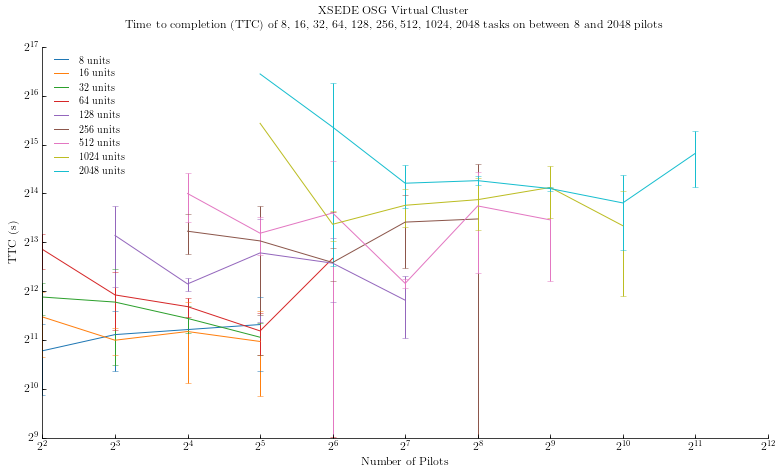

In [7]:
fig, ax = fig_setup()
title_head = 'XSEDE OSG Virtual Cluster'
title_desc = 'Time to completion (TTC) of 8, 16, 32, 64, 128, 256, 512, 1024, 2048 tasks on between 8 and 2048 pilots'
title = '%s\n%s' % (title_head, title_desc)
fig.suptitle(title)

ttc = sessions[
    ['npilot','TTC','nunit_requested']].groupby(
        ['npilot','nunit_requested']).aggregate(
            {'TTC':{'TTC_mean':'mean','TTC_std':'std'}})
ttc.columns = ttc.columns.droplevel(0)
ttc = ttc.reset_index()

#display(ttc)
colors=[tableau20[0] , tableau20[2] , tableau20[4] , tableau20[6] , 
        tableau20[8] , tableau20[10], tableau20[12], tableau20[14], 
        tableau20[16], tableau20[18], tableau20[20], tableau20[1] ,
        tableau20[3] , tableau20[5] , tableau20[7] , tableau20[9] ,
        tableau20[11], tableau20[13], tableau20[15], tableau20[17],
        tableau20[19]]

nus = ttc['nunit_requested'].unique()
nus.sort()

for nu in nus:
    ttc.loc[ttc['nunit_requested']==nu].plot(x='npilot', y='TTC_mean', yerr='TTC_std', 
                                             label=str(int(nu))+' units',
                                             color=colors.pop(0),
                                             ax=ax)

ax.set_xscale('log', basex=2)
ax.set_yscale('log', basey=2)
ax.set_xlim((0, 2**12))
ax.set_xlabel('Number of Pilots')
ax.set_ylabel('TTC (s)')

plt.savefig('figures/osg_ttc_pilots.pdf', dpi=600, bbox_inches='tight')

### Total Task Execution Time (TTX)

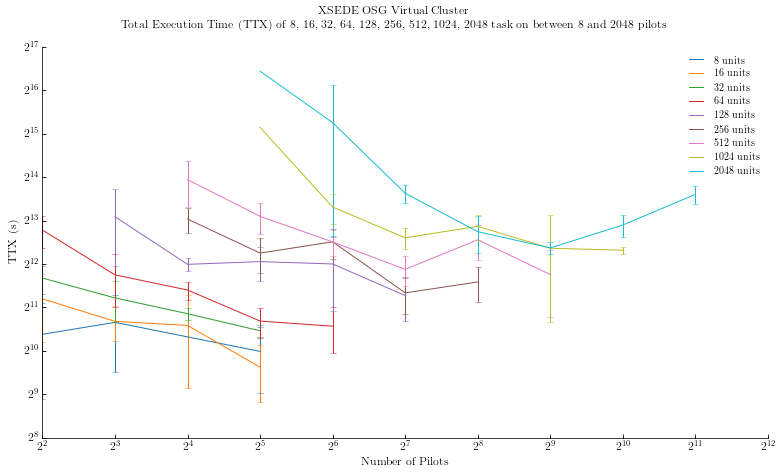

In [8]:
fig, ax = fig_setup()
title_head = 'XSEDE OSG Virtual Cluster'
title_desc = 'Total Execution Time (TTX) of 8, 16, 32, 64, 128, 256, 512, 1024, 2048 task on between 8 and 2048 pilots'
title = '%s\n%s' % (title_head, title_desc)
fig.suptitle(title)

ttx = sessions[
    ['npilot','U_AGENT_EXECUTING','nunit_requested']].groupby(
        ['npilot','nunit_requested']).aggregate(
            {'U_AGENT_EXECUTING':{'TTX_mean':'mean','TTX_std':'std'}})
ttx.columns = ttx.columns.droplevel(0)
ttx = ttx.reset_index()

#display(ttc)
colors=[tableau20[0] , tableau20[2] , tableau20[4] , tableau20[6] , 
        tableau20[8] , tableau20[10], tableau20[12], tableau20[14], 
        tableau20[16], tableau20[18], tableau20[20], tableau20[1] ,
        tableau20[3] , tableau20[5] , tableau20[7] , tableau20[9] ,
        tableau20[11], tableau20[13], tableau20[15], tableau20[17],
        tableau20[19]]

nus = ttc['nunit_requested'].unique()
nus.sort()

for nu in nus:
    ttx.loc[ttc['nunit_requested']==nu].plot(x='npilot', y='TTX_mean', yerr='TTX_std', 
                                             label=str(int(nu))+' units',
                                             color=colors.pop(0),
                                             ax=ax)

ax.set_xscale('log', basex=2)
ax.set_yscale('log', basey=2)
ax.set_xlim((0, 2**12))
ax.set_xlabel('Number of Pilots')
ax.set_ylabel('TTX (s)')

plt.savefig('figures/osg_ttx_pilots.pdf', dpi=600, bbox_inches='tight')

### Total Pilot Queuing Time (TTQ)

NOTE: There may be something wrong with a couple of data point responsible for the off-the-chart error bars. I found a similar problem with TTC. Will need to investigate further.

In [9]:
sessions[(sessions['npilot']==64) & (sessions['nunit_requested']==2048)][['experiment','npilot','TTC','P_LRMS_QUEUING','nunit_requested']]

,experiment,npilot,TTC,P_LRMS_QUEUING,nunit_requested
rp.session.radical.mturilli.017131.0001,exp9,64,39116.7173,402.1958,2048.0
rp.session.radical.mturilli.017131.0005,exp9,64,94050.8625,63879.8725,2048.0
rp.session.radical.mturilli.017133.0001,exp9,64,17867.1074,417.4258,2048.0
rp.session.radical.mturilli.017133.0003,exp9,64,17031.7817,614.9169,2048.0


See https://github.com/radical-cybertools/radical.analytics/issues/25 for an analysis of the outlier rp.session.radical.mturilli.017131.0005. It seems we did hit $T_q$ indeed. That anlysis confirmed the relevance of the following two questions:
1. Average number of units executed per pilots;
2. Number of available pilots at 'every' point in time of the execution.

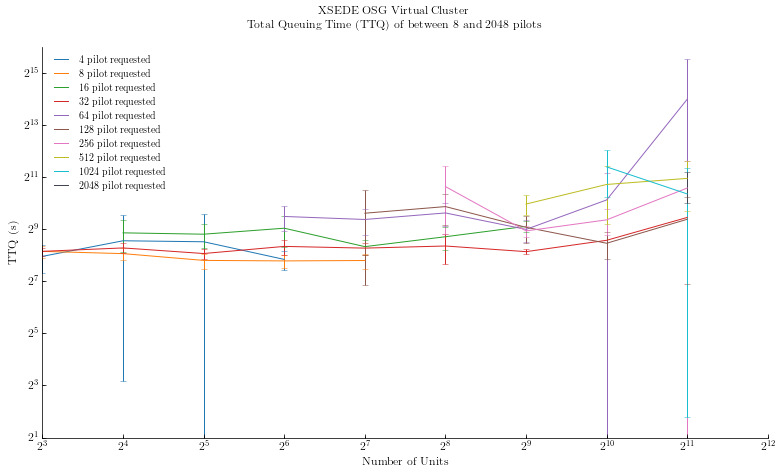

In [10]:
fig, ax = fig_setup()
title_head = 'XSEDE OSG Virtual Cluster'
title_desc = 'Total Queuing Time (TTQ) of between 8 and 2048 pilots'
title = '%s\n%s' % (title_head, title_desc)
fig.suptitle(title)

ttq = sessions[
    ['npilot','P_LRMS_QUEUING','nunit_requested']].groupby(
        ['npilot','nunit_requested']).aggregate(
            {'P_LRMS_QUEUING':{'TTQ_mean':'mean','TTQ_std':'std'}})
ttq.columns = ttq.columns.droplevel(0)
ttq = ttq.reset_index()

#display(ttc)
colors=[tableau20[0] , tableau20[2] , tableau20[4] , tableau20[6] , 
        tableau20[8] , tableau20[10], tableau20[12], tableau20[14], 
        tableau20[16], tableau20[18], tableau20[20], tableau20[1] ,
        tableau20[3] , tableau20[5] , tableau20[7] , tableau20[9] ,
        tableau20[11], tableau20[13], tableau20[15], tableau20[17],
        tableau20[19]]

nps = ttq['npilot'].unique()
nps.sort()

for np in nps:
    ttq.loc[ttc['npilot']==np].plot(x='nunit_requested', y='TTQ_mean', yerr='TTQ_std', 
                                             label=str(int(np))+' pilot requested',
                                             color=colors.pop(0),
                                             ax=ax)

ax.set_xscale('log', basex=2)
ax.set_yscale('log', basey=2)
ax.set_xlim((0, 2**12))
ax.set_xlabel('Number of Units')
ax.set_ylabel('TTQ (s)')

plt.savefig('figures/osg_ttq_pilots.pdf', dpi=600, bbox_inches='tight')

### Tasks Execution Time ($T_x$)

* What is the distribution of $T_x$?
* What is the distribution of $T_x$ per host?
* What is the distribution of $T_x$ per experiment?

NormaltestResult(statistic=65977.267038505292, pvalue=0.0)

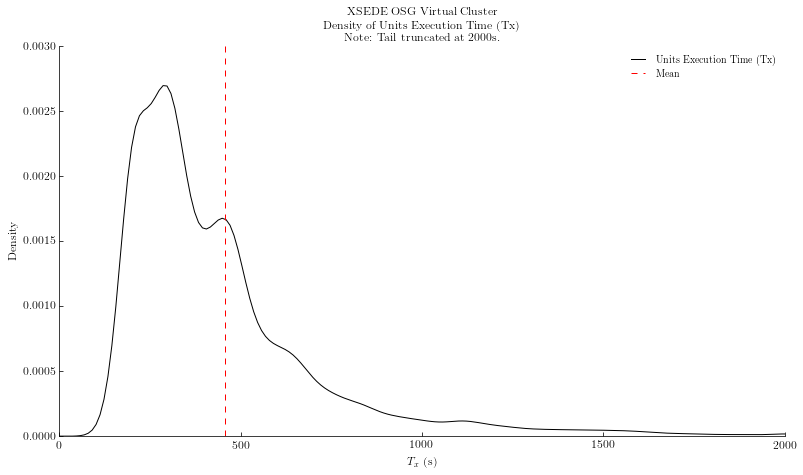

In [11]:
fig, ax = fig_setup()
title='XSEDE OSG Virtual Cluster\nDensity of Units Execution Time (Tx)\nNote: Tail truncated at 2000s.'

display(sps.normaltest(units['U_AGENT_EXECUTING'].dropna().tolist()))
units[['U_AGENT_EXECUTING']].dropna().reset_index(drop=True).plot.density(ax=ax, color='black', title=title)

#plt.axvline(units['U_AGENT_EXECUTING'].min(),  color='r', linestyle='dashed', linewidth=1)
plt.axvline(units['U_AGENT_EXECUTING'].dropna().mean(), color='r', linestyle='dashed', linewidth=1)
#plt.axvline(units['U_AGENT_EXECUTING'].max(),  color='r', linestyle='dashed', linewidth=1)

#ax.set_xlim((0, units['U_AGENT_EXECUTING'].max()+100))
ax.set_xlim(0, 2000)
ax.set_xlabel('$T_x$ (s)')
ax.legend(labels=['Units Execution Time (Tx)', 'Mean'])

plt.savefig('figures/osg_tx_all_frequency.pdf', dpi=600, bbox_inches='tight')

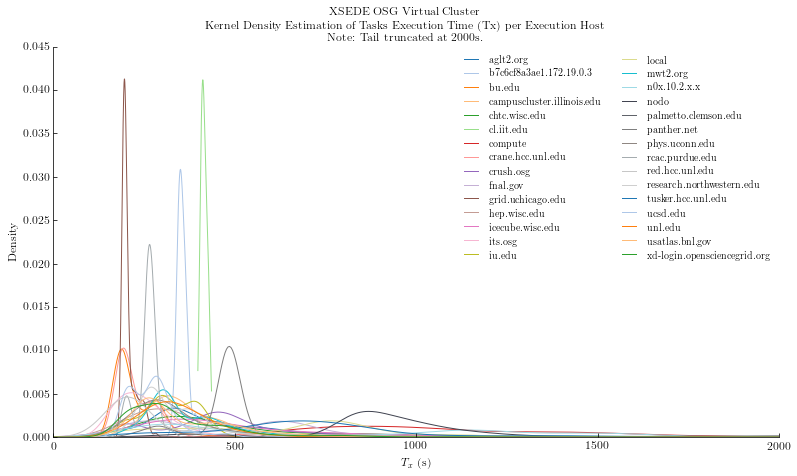

In [12]:
fig, ax = fig_setup()

title='XSEDE OSG Virtual Cluster\nKernel Density Estimation of Tasks Execution Time (Tx) per Execution Host\nNote: Tail truncated at 2000s.'
fig.suptitle(title)

curves = {}
hosts = units['hid'].dropna().unique()

minni = units.loc[units['U_AGENT_EXECUTING'].notnull()]

for host in hosts:
    curves[host] = minni.loc[units['hid'] == host]['U_AGENT_EXECUTING'].dropna().reset_index(drop=True)

curves = dict((k.lower(), v) for k,v in curves.iteritems())    
utxh = pd.DataFrame(curves) 
utxh.plot.density(ax=ax, sort_columns=True, color=tableau20)#, linewidth=2)#, figsize=(15, 13), title=title) # subplots=True, layout=(4,4), sharey=True, sharex=True,

ax.legend(ncol=2)
ax.set_xlim((0, 2000))
ax.set_xlim((0))
ax.set_xlabel('$T_x$ (s)')

plt.savefig('figures/osg_tx_hosts_frequency.pdf', dpi=600, bbox_inches='tight')

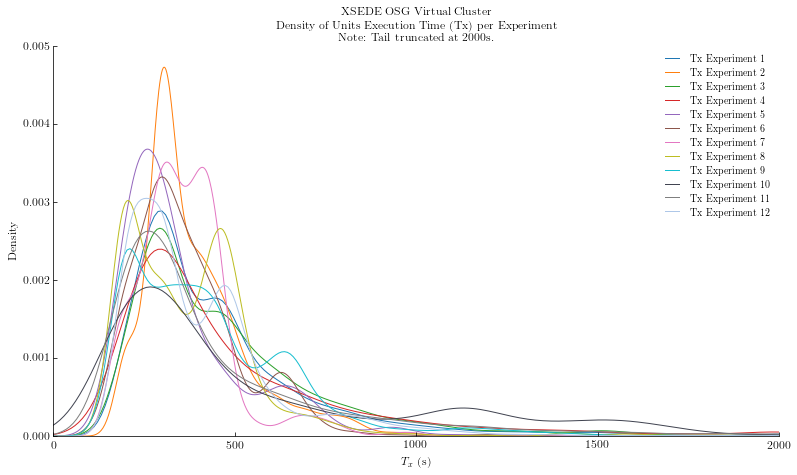

In [13]:
fig, ax = fig_setup()
title='XSEDE OSG Virtual Cluster\nDensity of Units Execution Time (Tx) per Experiment\nNote: Tail truncated at 2000s.'

tx_exp1  = units[units['experiment'].str.contains('exp1' )]['U_AGENT_EXECUTING'].dropna().reset_index(drop=True)
tx_exp2  = units[units['experiment'].str.contains('exp2' )]['U_AGENT_EXECUTING'].dropna().reset_index(drop=True)
tx_exp3  = units[units['experiment'].str.contains('exp3' )]['U_AGENT_EXECUTING'].dropna().reset_index(drop=True)
tx_exp4  = units[units['experiment'].str.contains('exp4' )]['U_AGENT_EXECUTING'].dropna().reset_index(drop=True)
tx_exp5  = units[units['experiment'].str.contains('exp5' )]['U_AGENT_EXECUTING'].dropna().reset_index(drop=True)
tx_exp6  = units[units['experiment'].str.contains('exp6' )]['U_AGENT_EXECUTING'].dropna().reset_index(drop=True)
tx_exp7  = units[units['experiment'].str.contains('exp7' )]['U_AGENT_EXECUTING'].dropna().reset_index(drop=True)
tx_exp8  = units[units['experiment'].str.contains('exp8' )]['U_AGENT_EXECUTING'].dropna().reset_index(drop=True)
tx_exp9  = units[units['experiment'].str.contains('exp9' )]['U_AGENT_EXECUTING'].dropna().reset_index(drop=True)
tx_exp10 = units[units['experiment'].str.contains('exp10')]['U_AGENT_EXECUTING'].dropna().reset_index(drop=True)
tx_exp11 = units[units['experiment'].str.contains('exp11')]['U_AGENT_EXECUTING'].dropna().reset_index(drop=True)
tx_exp12 = units[units['experiment'].str.contains('exp12')]['U_AGENT_EXECUTING'].dropna().reset_index(drop=True)

utxs = pd.DataFrame({'exp1': tx_exp1  , 'exp2': tx_exp2  , 'exp3': tx_exp3, 
                     'exp4': tx_exp4  , 'exp5': tx_exp5  , 'exp6': tx_exp6, 
                     'exp7': tx_exp7  , 'exp8': tx_exp8  , 'exp9': tx_exp9,
                     'exp10': tx_exp10, 'exp11': tx_exp11, 'exp12': tx_exp12})

utxs.plot.density(ax=ax, color=[tableau20[0 ],tableau20[2 ],tableau20[4 ],
                                tableau20[6 ],tableau20[8 ],tableau20[10],
                                tableau20[12],tableau20[14],tableau20[16],
                                tableau20[18],tableau20[20],tableau20[1]], title=title)

ax.set_xlim((0, 2000))
ax.set_xlabel('$T_x$ (s)')
ax.legend(labels=['Tx Experiment 1' , 'Tx Experiment 2' , 'Tx Experiment 3', 
                  'Tx Experiment 4' , 'Tx Experiment 5' , 'Tx Experiment 6',
                  'Tx Experiment 7' , 'Tx Experiment 8' , 'Tx Experiment 9',
                  'Tx Experiment 10', 'Tx Experiment 11', 'Tx Experiment 12'])

plt.savefig('figures/osg_tx_experiments_frequency.pdf', dpi=600, bbox_inches='tight')

### Pilot Queue Waiting Time ($T_q$)

* What is the distribution of $T_x$?
* What is the distribution of $T_x$ per host?
* What is the distribution of $T_x$ per experiment?

NormaltestResult(statistic=38132.711362462447, pvalue=0.0)

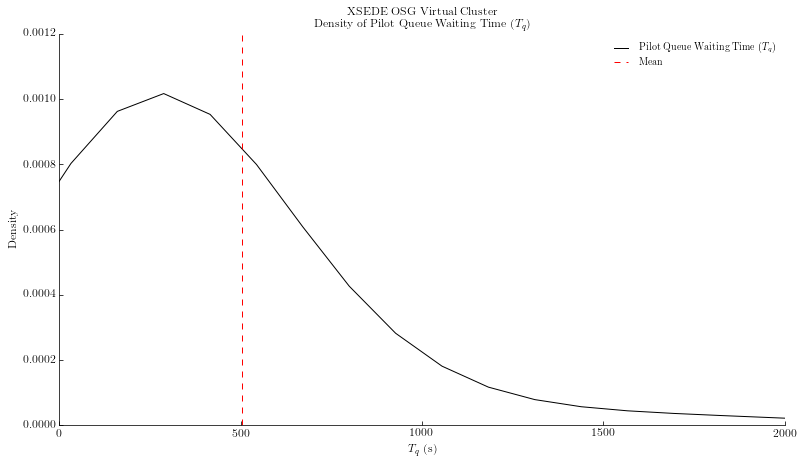

In [14]:
fig, ax = fig_setup()
title='XSEDE OSG Virtual Cluster\nDensity of Pilot Queue Waiting Time ($T_q$)'#\nNote: Tail truncated at 2000s.'

display(sps.normaltest(pilots['P_LRMS_QUEUING'].dropna().tolist()))
# display(pilots[['P_PMGR_QUEUING']].dropna())
pilots.loc[pilots['nunit']>1][['P_LRMS_QUEUING']].dropna().reset_index(drop=True).plot.density(ax=ax, color='black', title=title)

#plt.axvline(units['U_AGENT_EXECUTING'].min(),  color='r', linestyle='dashed', linewidth=1)
plt.axvline(pilots['P_LRMS_QUEUING'].dropna().mean(), color='r', linestyle='dashed', linewidth=1)
#plt.axvline(units['U_AGENT_EXECUTING'].max(),  color='r', linestyle='dashed', linewidth=1)

#ax.set_xlim((0, units['U_AGENT_EXECUTING'].max()+100))
ax.set_xlim(0, 2000)
ax.set_xlabel('$T_q$ (s)')
ax.legend(labels=['Pilot Queue Waiting Time ($T_q$)', 'Mean'])

plt.savefig('figures/osg_tq_all_frequency.pdf', dpi=600, bbox_inches='tight')

Single pilot queue time is ~8.3 minutes on average with a fairly long tail. The impact of the tail on execution time needs to be investigated by comparing it to the average TTQ, i.e. the total time spent queuing as a portion of TTC. This comparison tells us whether the pilots of the long tail waiting a long time while **other** pilots were already active. This is also a good measure of the importance of late binding with back filling on pilots on OSG and, ultimately, a justification of the use of single-core pilots. For this reason, the very long tail could be good news for the need to position/justify the paper.

### Pilot Running Time ($T_r$)

* What is the distribution of $T_r$?
* What is the distribution of $T_r$ per host?
* What is the distribution of $T_r$ per experiment?

NormaltestResult(statistic=13130.223244947589, pvalue=0.0)

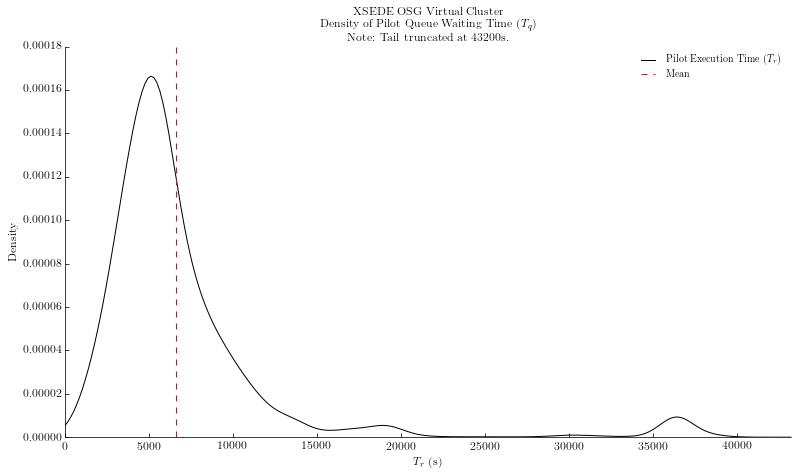

In [15]:
fig, ax = fig_setup()
title='XSEDE OSG Virtual Cluster\nDensity of Pilot Queue Waiting Time ($T_q$)\nNote: Tail truncated at 43200s.'

display(sps.normaltest(pilots['P_LRMS_RUNNING'].dropna().tolist()))
# display(pilots[['P_PMGR_QUEUING']].dropna())
pilots.loc[pilots['nunit']>1][['P_LRMS_RUNNING']].dropna().reset_index(drop=True).plot.density(ax=ax, color='black', title=title)

#plt.axvline(units['U_AGENT_EXECUTING'].min(),  color='r', linestyle='dashed', linewidth=1)
plt.axvline(pilots['P_LRMS_RUNNING'].dropna().mean(), color='r', linestyle='dashed', linewidth=1)
#plt.axvline(units['U_AGENT_EXECUTING'].max(),  color='r', linestyle='dashed', linewidth=1)

# ax.set_xlim((0, units['U_AGENT_EXECUTING'].max()+100))
ax.set_xlim(0, 43200)
ax.set_xlabel('$T_r$ (s)')
ax.legend(labels=['Pilot Execution Time ($T_r$)', 'Mean'])

plt.savefig('figures/osg_tr_all_frequency.pdf', dpi=600, bbox_inches='tight')

Pilots are active for an average of mostly 2 hours. Next step is to look at average duration of pilots during runtime: do the pilots terminate becuase there are no more tasks to run or is there a dominant average time in which the pilots are active and then are terminated/preempted?

### Resource Dynamism
* How many resources are used on average for each experiment' BoT?
* Does the number of resources vary among experiments' BoT?
* Does the number of resources vary during the execution of each experiment's BoT?

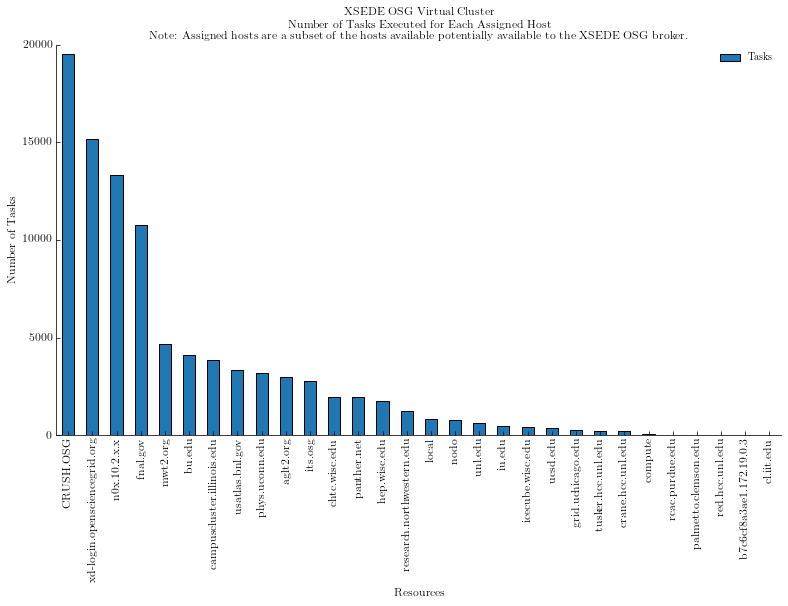

In [16]:
fig, ax = fig_setup()

title='XSEDE OSG Virtual Cluster\nNumber of Tasks Executed for Each Assigned Host\nNote: Assigned hosts are a subset of the hosts available potentially available to the XSEDE OSG broker.'

us = units
us[['hid', 'uid']].groupby('hid').count().sort_values(by='uid', ascending=False).plot.bar(ax=ax, color=tableau20[0], title=title)

ax.set_xlabel('Resources')
ax.set_ylabel('Number of Tasks')
ax.legend(labels=['Tasks'])

plt.savefig('figures/osg_nunits_per_host.pdf', dpi=600, bbox_inches='tight')

### Pilot Dynamism
* How many active pilots are used on average for each experiment's BoT?
* Does the number of active pilots vary among experiments' BoT?
* Does the number of active pilots vary during the execution of each experiment's BoT?

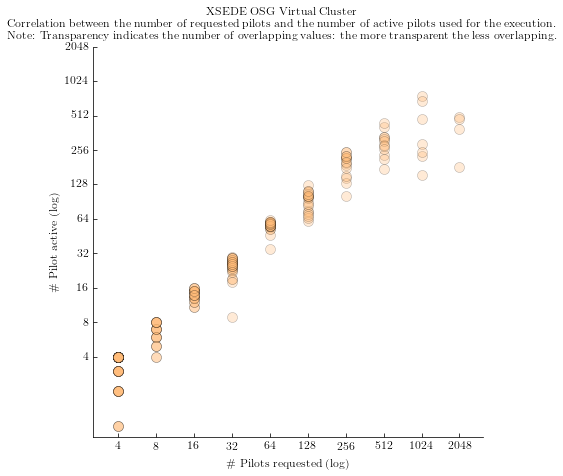

In [17]:
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111)  
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)  
ax.get_xaxis().tick_bottom()  
ax.get_yaxis().tick_left()
    
title='XSEDE OSG Virtual Cluster\n'+\
'Correlation between the number of requested pilots and the number of active pilots used for the execution.\n'+\
'Note: Transparency indicates the number of overlapping values: the more transparent the less overlapping.'
fig.suptitle(title)

qui = sessions.rename(columns={'npilot_active':'NpActive'}).copy()
ax.scatter(qui['npilot'], qui['NpActive'], s=100, facecolor=tableau20[3], alpha=0.3, lw=0.5)

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim((10**0.4, 10**3.5))#-50, 550))
ax.set_ylim((10**-0.1, 10**3.2))

plt.minorticks_off()
plt.xticks([4,8,16,32,64,128,256,512,1024,2048], [4,8,16,32,64,128,256,512,1024,2048])
plt.yticks([4,8,16,32,64,128,256,512,1024,2048], [4,8,16,32,64,128,256,512,1024,2048])
plt.xlabel('\# Pilots requested (log)')
plt.ylabel('\# Pilot active (log)')

plt.savefig('figures/osg_scatter_npilots-requested_npilots-active.pdf', dpi=600, bbox_inches='tight')

### Correlation Between Resource and Pilot Dynamism
* Does the number of resources used for each experiment's BoT execution correlate to the number of pilots requested?
* Does the number of resources used for each experiment's BoT execution correlate to the number of active pilots?
* Does the variation of the number of pilots correlate to variation of the number of resources during runtime?

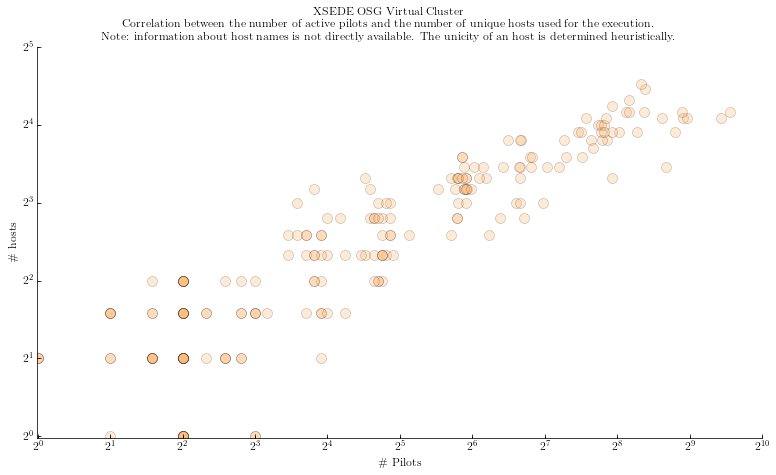

In [18]:
fig, ax = fig_setup()

title='XSEDE OSG Virtual Cluster\n'+\
'Correlation between the number of active pilots and the number of unique hosts used for the execution.\n'+\
'Note: information about host names is not directly available. The unicity of an host is determined heuristically.'
fig.suptitle(title)

paperino = sessions.copy()
ax.scatter(paperino['npilot_active'], paperino['nhost'], s=100, alpha=0.3, facecolor=tableau20[3], lw=0.5)

ax.set_xscale('log', basex=2)
ax.set_yscale('log', basey=2)
plt.xlabel('\# Pilots')
plt.ylabel('\# hosts')
ax.set_xlim((-10))
ax.set_ylim((0))

plt.savefig('figures/osg_scatter_npilots-active_nhosts.pdf', dpi=600, bbox_inches='tight')

The number of active pilots of an execution seems to correlate positevely and strongly to the number of hosts used for the execution. The relation between the two variables seems to be monotonic with a relatively low number of outliner. We calculate the sample Pearson and Spearman correlation coefficients for testing non-correlation~\mtnote{For non-linear monotonic relations Pearson test is adequate to indicate the existence and direction of statistical dependence, less adequate to indicate its strenght. Pearson test is sensitive to outliners while Spearman is not. Also, Spearman seems more adequate with high level of skewness, that we have.}. 

In [22]:
# Get Pearson r and p-value
r,pv = sps.pearsonr(paperino['npilot_active'], paperino['nhost'])
rho,rpv = sps.spearmanr(paperino['npilot_active'], paperino['nhost'])
tau,tpv = sps.kendalltau(paperino['npilot_active'], paperino['nhost'])

# Use the Fisher transformation to get z
z = np.arctanh(r)

# Calculate sigma (std error) of sampling distribution size N (i.e., N of paperino) 
# of z (assumed to be approximately normally distributed). 
# The formulat is $\frac{1}{\sqrt[N-3]}$
sigma = (1/((len(paperino.index)-3)**0.5))

# Get normal 95% interval probability density function for normal
# continuous random variable apply two-sided conditional formula
cint = z + np.array([-1, 1]) * sigma * sps.norm.ppf((1+0.95)/2)

# take hyperbolic tangent to get interval values for 95%
rcint = np.tanh(cint)

print '(Pearson) r = %s\n(Spearman) rho = %s\n(Kendall) tau = %s\nz = %s\nsigma = %s\n95%% confidence interval = %s' % (r, rho, tau, z, sigma, rcint)

(Pearson) r = 0.810690973249
(Spearman) rho = 0.919114689263
(Kendall) tau = 0.779443255561
z = 1.12904153131
sigma = 0.0701862406344
95% confidence interval = [ 0.75799228  0.85287457]


We test whether the two distributions of number of active pilots and number of hosts are approximately normal by performing a chi squared test. When the two distribution are not normal, the correlation provides an incomplete description of the association.

Note: the following distributions depend on the number of runs performed in the experiments. The more runs with a greater number of requested pilots, the less skewned the distributions. This is probably an indication we should look into balancing the number of runs across the experiments. At the moment, this is unbalanced towards lower values of requested pilots (and therefore active pilots and lower number of hosts, assuming correlation between requested pilots and active pilots; and active pilots and number of hosts).

NormaltestResult(statistic=20.958537213805087, pvalue=2.8113276865269914e-05)

(0, 35.0)

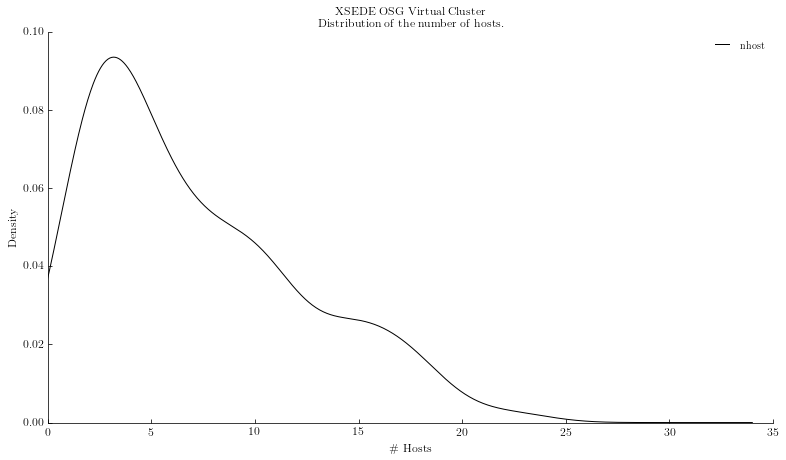

In [23]:
fig, ax = fig_setup()

title='XSEDE OSG Virtual Cluster\nDistribution of the number of hosts.'

display(sps.normaltest(paperino['nhost'].dropna().tolist()))
paperino[['nhost']].dropna().reset_index(drop=True).plot.density(ax=ax, color='black', title=title)

plt.xlabel('\# Hosts')
ax.set_xlim(0)
    
# plt.savefig('figures/osg_scatter_npilots-active_nhosts.pdf', dpi=600, bbox_inches='tight')

NormaltestResult(statistic=139.5509324684449, pvalue=4.9762253838488092e-31)

(0, 1200.0)

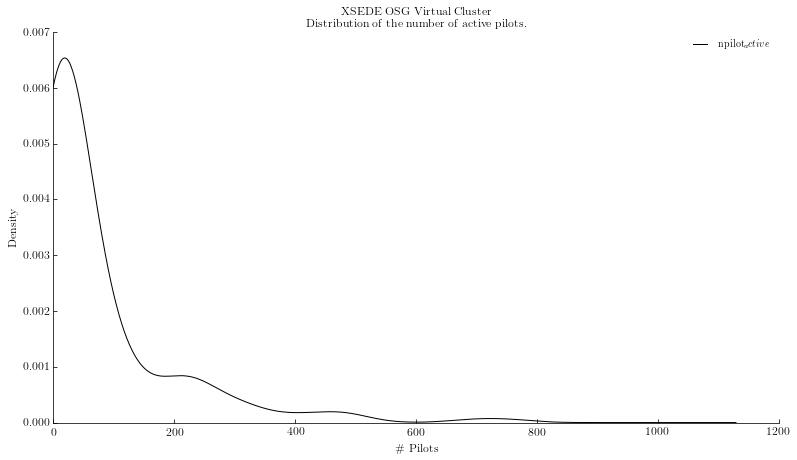

In [24]:
fig, ax = fig_setup()

title='XSEDE OSG Virtual Cluster\nDistribution of the number of active pilots.'

display(sps.mstats.normaltest(paperino['npilot_active'].dropna().tolist()))
paperino[['npilot_active']].dropna().reset_index(drop=True).plot.density(ax=ax, color='black', title=title)

plt.xlabel('\# Pilots')
ax.set_xlim(0)

# plt.savefig('figures/osg_scatter_npilots-active_nhosts.pdf', dpi=600, bbox_inches='tight')

Both the sample Pearson and Spearman tests suggests correlation: the more active pilots the more hosts are used for the execution. This has relevant implications:

* the number of pilots that can become active on every resource is limited. If we bypass or 'direct' the resource selection operated by the XOVC, we will have to select a pool with a number of hosts proportional to the number of pilots that we request.
* The number of pilots that can become concurrently active is likely to be bounded. As the number of hosts is upper bounded, once all the host available have been used to execute some pilot, no more pilot will become active. This is confirmed by the plot under the subsection 'Pilot dynamism': the number of concurrent active pilots seems to cap at around 512. 

### Correlation Between Resource Dynamism and TTC
* Does the number of resources used to execute experiments' BoT correlate to variations in the BoT TTC?
* Does the variation of the number of resources during the execution of the experiments' BoT correlate to the BoT TTC?

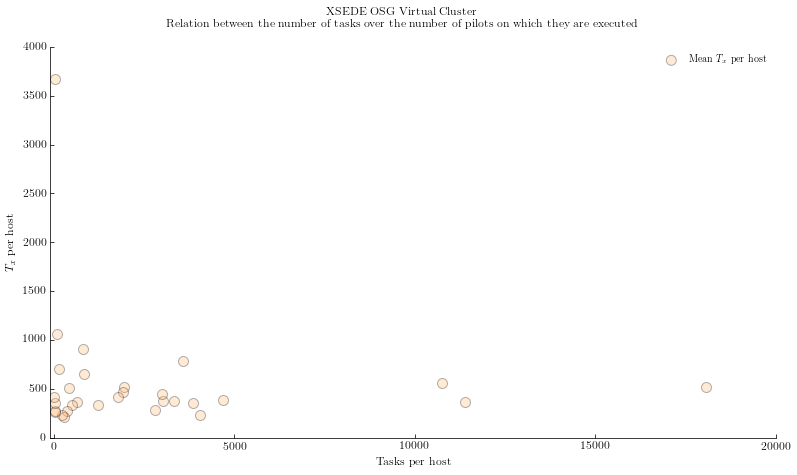

In [25]:
fig, ax = fig_setup()

title='XSEDE OSG Virtual Cluster\n'+\
'Relation between '+\
'the number of tasks over the number of pilots on which they are executed'
fig.suptitle(title)

pluto = units
x = pluto.loc[pluto['U_AGENT_EXECUTING'].notnull()][['hid', 'uid']].groupby('hid').count()
y1 = pluto[['U_AGENT_EXECUTING', 'hid']].dropna().groupby('hid').min().add_prefix('min_')
y2 = pluto[['U_AGENT_EXECUTING', 'hid']].dropna().groupby('hid').mean().add_prefix('mean_')
y3 = pluto[['U_AGENT_EXECUTING', 'hid']].dropna().groupby('hid').max().add_prefix('max_')
scatter = pd.concat([x, y1, y2, y3], axis=1).sort_values(by='uid', ascending=False)

# display(scatter)

# scatter.plot.scatter('uid', 'min_U_AGENT_EXECUTING', s=100, ax=ax, color=tableau20[1], lw=0.5)

# ax.scatter(scatter['uid'], scatter['min_U_AGENT_EXECUTING'], s=100, facecolor=tableau20[1], label='Min $T_x$ per host')
ax.scatter(scatter['uid'], scatter['mean_U_AGENT_EXECUTING'], s=100, alpha=0.3, facecolor=tableau20[3], label='Mean $T_x$ per host')
# ax.scatter(scatter['uid'], scatter['max_U_AGENT_EXECUTING'], s=100, facecolor=tableau20[5], label='Max $T_x$ per host')

plt.xlabel('# Tasks per host')
plt.ylabel('$T_x$ per host')
ax.set_xlim((-100))
# ax.set_ylim((0, 6000))
ax.legend(scatterpoints=1)

plt.savefig('figures/osg_scatter_task-per-host_tx-per-host.pdf', dpi=600, bbox_inches='tight')

### Correlation Between Pilot Dynamism and TTC
* Does the number of active pilots used to execute experiments' BoT correlate to variations in the BoT TTC?
* Does the variation of the number of active pilots during the execution of the experiments' BoT correlate to the BoT TTC?
* Does the ration between active pilots and single hosts correlate to the BoT TTC?

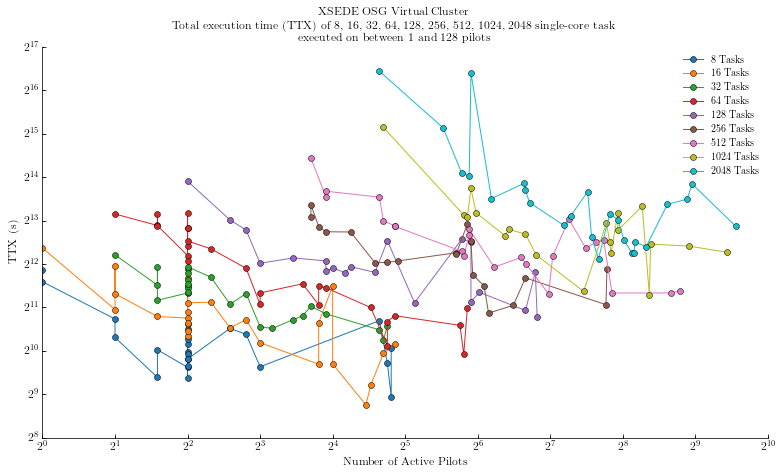

In [26]:
fig, ax = fig_setup()
fig.suptitle('XSEDE OSG Virtual Cluster\nTotal execution time (TTX) of 8, 16, 32, 64, 128, 256, 512, 1024, 2048 single-core task\nexecuted on between 1 and 128 pilots')

s = sessions.rename(columns={'npilot_active':'npilotactive'})

colors=[tableau20[0], tableau20[2],  tableau20[4],  tableau20[6], 
        tableau20[8], tableau20[10], tableau20[12], tableau20[14], 
        tableau20[16], tableau20[18], tableau20[20], tableau20[1],
        tableau20[3], tableau20[5], tableau20[7], tableau20[9],
        tableau20[11], tableau20[13], tableau20[15], tableau20[17],
        tableau20[19]]

for u in s['nunit_requested'].dropna().astype(int).sort_values().unique().tolist():
    unts = s[s['nunit_requested']==u][['U_AGENT_EXECUTING', 'npilotactive']].dropna().sort_values('npilotactive').copy()
    ax.plot(unts.npilotactive, unts.U_AGENT_EXECUTING, marker='o', label='%s Tasks' % u, color=colors.pop(0))

#ax.xaxis.set_major_locator(ticker.MultipleLocator(4))
ax.set_xscale('log', basex=2)
ax.set_yscale('log', basey=2)
ax.legend(numpoints=1)
ax.set_xlabel('Number of Active Pilots')
ax.set_ylabel('TTX (s)')

plt.savefig('figures/osg_ttx_active-pilots.pdf', dpi=600, bbox_inches='tight')

NOTE: The use of the estimated regression probably makes no sense in this context. I use it as a placeholder to remember myself to study about it.

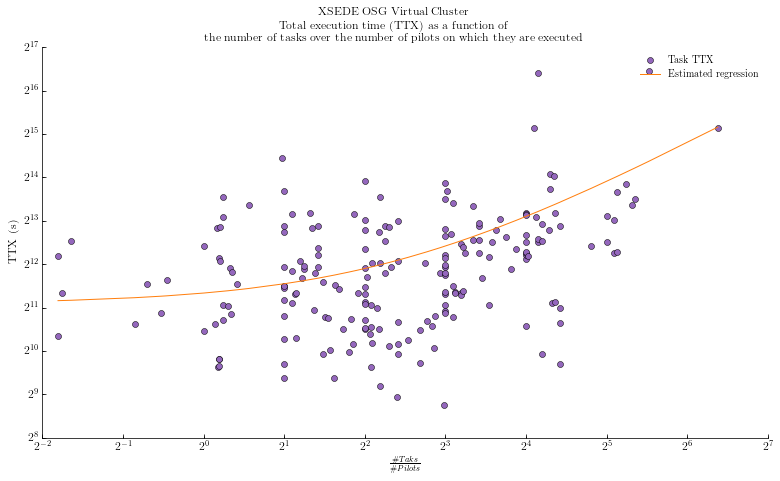

In [27]:
fig, ax = fig_setup()

fig.suptitle('XSEDE OSG Virtual Cluster\nTotal execution time (TTX) as a function of\nthe number of tasks over the number of pilots on which they are executed')

s = sessions.rename(columns={'npilot_active':'NpActive'})
s['NuOnNpActive'] = s['nunit']/s['NpActive']

x = s['NuOnNpActive'].dropna().sort_values()
y = s['U_AGENT_EXECUTING'].dropna()
fit = np.polyfit(x, y, 1)
fit_fn = np.poly1d(fit)

ax.plot(x, y, marker='o', color=tableau20[8], linestyle='', label='Task TTX')
ax.plot(x, fit_fn(x), color=tableau20[2], label='Estimated regression')

ax.set_xscale('log', basex=2)
ax.set_yscale('log', basey=2)
plt.xlabel(r'$\frac{\#Taks}{\#Pilots}$')
plt.ylabel('TTX (s)')
ax.legend(numpoints=1)

plt.savefig('figures/osg_ttx_nunit_over_nactive-pilots.pdf', dpi=600, bbox_inches='tight')

### Resource Heterogeneity
* Is there a direct/indirect measurement of CPU heterogeneity across resources used to execute experiments' BoT?
* Is there a direct/indirect measurement of geographical heterogeneity across resources used to execute experiments' BoT?
* Is there a direct/indirect measurement of software stack heterogeneity across resources used to execute experiments' BoT?

### Correlation Between Resource Heterogeneity and TTC
* Does the degree of CPU heterogeneity across resources used to execute experiments' BoT correlate to the BoT TTC?
* Does the degree of geographical heterogeneity across resources used to execute experiments' BoT correlate to the BoT TTC?
* Does the degree of software stack heterogeneity across resources used to execute experiments' BoT correlate to the BoT TTC?

### Failure and Rescheduling

* Is there a set of hosts on which units are often scheduled but often fail to execute?

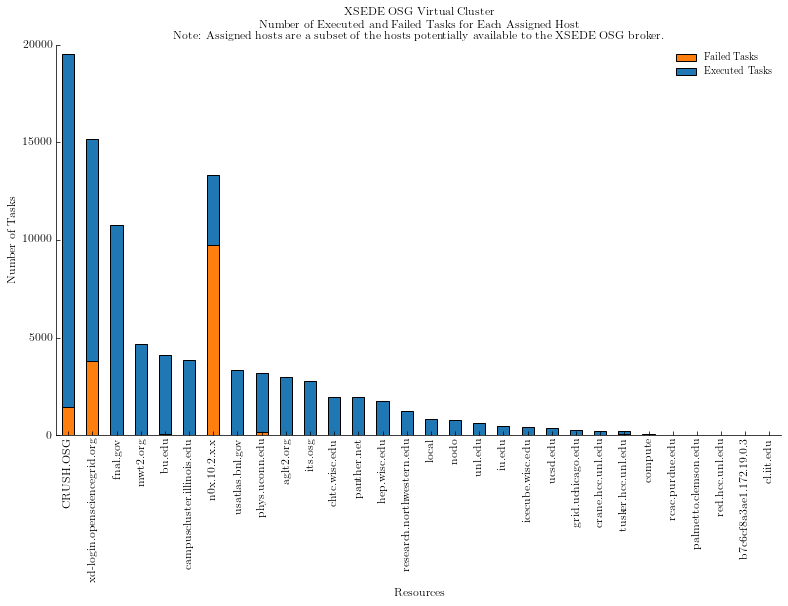

In [28]:
fig, ax = fig_setup()

title='XSEDE OSG Virtual Cluster\n'+\
'Number of Executed and Failed Tasks for Each Assigned Host\n'+\
'Note: Assigned hosts are a subset of the hosts potentially available to the XSEDE OSG broker.'

pippo = units

pd.concat(
    [pippo.loc[pippo['U_AGENT_EXECUTING'].isnull()][['hid', 'uid']].groupby('hid').count().rename(columns={'uid':'Failed Tasks'}),
     pippo.loc[pippo['U_AGENT_EXECUTING'].notnull()][['hid', 'uid']].groupby('hid').count().rename(columns={'uid':'Executed Tasks'})], 
    axis=1).sort_values(
        by=['Executed Tasks','Failed Tasks'], 
        ascending=False).plot.bar(
            ax=ax, 
            stacked=True, 
            color=[tableau20[2],tableau20[0]], 
            title=title)

ax.set_xlabel('Resources')
ax.set_ylabel('Number of Tasks')

plt.savefig('figures/osg_nunits_executed_failed_per_host.pdf', dpi=600, bbox_inches='tight')

## Conclusions
## Acknoledgments
## References

----------------------------------------------------------
# NOTES AND TESTS - PLS IGNORE

In [ ]:
display(units['U_AGENT_EXECUTING'].dropna().shape)
display(sessions['nunit_done'].sum())
pd.concat(
    [units.loc[units['U_AGENT_EXECUTING'].notnull()].groupby('sid').count()[['U_AGENT_EXECUTING']],
     sessions.loc[sessions['nunit_done'].isnull()]['nunit_done']], axis=1, join='inner')

In [ ]:
# TODO: Number of requsted pilots Vs number of active pilots (x = sessions; y = integers)

In [ ]:
# TODO: Number of unit rescheduled Vs TTC (x = TTC; y = number of units rescheduled)

In [ ]:
# fig = plt.figure(figsize=(18,20))

# title = 'XSEDE OSG Virtual Cluster'
# subtitle = 'TTQ, TTR, TTX and TTC with Number of Active Pilots (black) and Number of Unique Resources (red)'
# fig.suptitle('%s:\n%s.' % (title, subtitle), fontsize=16)

# defs = {'ttq': 'TTQ = Total Time Queuing pilots',
#         'ttr': 'TTR = Total Time Running pilots',
#         'ttx': 'TTR = Total Time Executing compute units',
#         'ttc': 'TTC = Total Time Completing experiment run'}
# defslist = '%s;\n%s;\n%s;\n%s.' % (defs['ttq'], defs['ttr'], defs['ttx'], defs['ttc'])
# plt.figtext(.38,.89, defslist, fontsize=14, ha='left')

# gs = []
# grid  = gridspec.GridSpec(3, 2)
# grid.update(wspace=0.4, hspace=0.4, top=0.825)
# gs.append(gridspec.GridSpecFromSubplotSpec(1, 4, subplot_spec=grid[0]))
# gs.append(gridspec.GridSpecFromSubplotSpec(1, 4, subplot_spec=grid[1]))
# gs.append(gridspec.GridSpecFromSubplotSpec(1, 4, subplot_spec=grid[2]))
# gs.append(gridspec.GridSpecFromSubplotSpec(1, 5, subplot_spec=grid[3]))
# gs.append(gridspec.GridSpecFromSubplotSpec(1, 7, subplot_spec=grid[4]))
# gs.append(gridspec.GridSpecFromSubplotSpec(1, 5, subplot_spec=grid[5]))

# ttq_subplots = []
# for exp in sessions['experiment'].sort_values().unique():
#     for nun in sessions['nunit_requested'].sort_values().unique():
#         if not sessions[(sessions['experiment'] == exp) & (sessions['nunit_requested'] == nun)].empty:
#             ttq_subplots.append(sessions[(sessions['experiment'] == exp) & (sessions['nunit_requested'] == nun) ].sort_values('TTC'))

# colors = {'exp1': [tableau20[6] ,tableau20[9],tableau20[8] ,tableau20[1]],
#           'exp2': [tableau20[6] ,tableau20[9],tableau20[8] ,tableau20[1]],
#           'exp3': [tableau20[6] ,tableau20[9],tableau20[8] ,tableau20[1]],
#           'exp4': [tableau20[6] ,tableau20[9],tableau20[8] ,tableau20[1]],
#           'exp5': [tableau20[6] ,tableau20[9],tableau20[8] ,tableau20[1]],
#           'exp6': [tableau20[6] ,tableau20[9],tableau20[8] ,tableau20[1]]}


# nun_exp = []
# nun_exp.append(len(sessions[sessions['experiment'] == 'exp1']['nunit_requested'].sort_values().unique()))
# nun_exp.append(len(sessions[sessions['experiment'] == 'exp2']['nunit_requested'].sort_values().unique()))
# nun_exp.append(len(sessions[sessions['experiment'] == 'exp3']['nunit_requested'].sort_values().unique()))
# nun_exp.append(len(sessions[sessions['experiment'] == 'exp4']['nunit_requested'].sort_values().unique()))
# nun_exp.append(len(sessions[sessions['experiment'] == 'exp5']['nunit_requested'].sort_values().unique()))
# nun_exp.append(len(sessions[sessions['experiment'] == 'exp6']['nunit_requested'].sort_values().unique()))

# ax = []
# i  = 0
# while(i < len(ttq_subplots)):
#     for gn in range(6):
#         for gc in range(nun_exp[gn]):
#             session = ttq_subplots.pop(0)
#             experiment = session['experiment'].unique()[0]
#             ntasks = int(session['nunit'].unique()[0])
#             npilots = int(session[session['experiment'] == experiment]['npilot'][0])
#             repetitions = session.shape[0]
#             color = colors[experiment]
#             title = 'Exp. %s\n%s tasks\n%s pilots\n%s rep.' % (experiment[3], ntasks, npilots, repetitions)
            
#             if i == 0:
#                 ax.append(plt.Subplot(fig, gs[gn][0, gc]))
#             else:
#                 ax.append(plt.Subplot(fig, gs[gn][0, gc], sharey=ax[0]))
#             session[['P_LRMS_QUEUING', 
#                      'P_LRMS_RUNNING',
#                      'U_AGENT_EXECUTING',
#                      'TTC']].plot(kind='bar', ax=ax[i], color=color, title=title, stacked=True)
#             ax[i].spines["top"].set_visible(False)
#             ax[i].spines["right"].set_visible(False)
#             ax[i].get_xaxis().tick_bottom()
#             ax[i].get_yaxis().tick_left()
#             ax[i].set_xticklabels([])
#             ax[i].set_xlabel('Runs')
            
#             # Handle a bug that sets yticklabels to visible 
#             # for the last subplot.
#             if i == 7 or i == 16 or i == 28:
#                 plt.setp(ax[i].get_yticklabels(), visible=False)
#             else:
#                 ax[i].set_ylabel('Time (s)')
                
#             # Handle legens.
#             if i == 3 or i == 11:
#                 ax[i].legend(labels=['TTQ','TTR','TTX','TTC'], bbox_to_anchor=(2.25, 1))
#             elif i == 23:
#                 ax[i].legend(labels=['TTQ','TTR','TTX','TTC'], bbox_to_anchor=(3.25, 1))
#             else:
#                 ax[i].get_legend().set_visible(False)
                
#             # Add labels.
#             rects = ax[i].patches
#             label_np = [int(l) for l in session['npilot_active']]
#             label_nh = [int(l) for l in session['nhost']]
#             nh = [r.get_height() for r in rects]
#             n = len(nh)/4              # Number of groups of 4 stacked bars
#             # partition the list of heights nh into number of bars n partitions;
#             # zip partitions into tuples t of n stacked bars;
#             # sum eacth tuple into the hight of n stacked bars.
#             heights = [sum(t) for t in zip(*[nh[j:j + n] for j in xrange(0, len(nh), n)])]
            
#             # Add labels with number of pilots requested per session.
#             for rect, label, height in zip(rects[-repetitions:], label_np, heights):
#                 ax[i].text(rect.get_x() + rect.get_width()/2, 
#                            height+3500, label, ha='center', va='bottom')
            
#             # Add labels with number of unique resources per session.
#             for rect, label, height in zip(rects[-repetitions:], label_nh, heights):
#                 ax[i].text(rect.get_x() + rect.get_width()/2, 
#                            height+500, label, ha='center', va='bottom', color='red')

#             fig.add_subplot(ax[i])
#             i += 1
            
# plt.savefig('figures/osg_experiment_comparison.pdf', dpi=600, bbox_inches='tight')

# Analysis Total Unit Execution Time ($TTX$)

# Analysis Total Pilot Queuing Time ($TTQ$)

# Analysis Unit Execution Time ($T_x$)

In [ ]:
units['U_AGENT_EXECUTING'].dropna().describe()

## Distribution of $T_x$

## Comparison of the Distribution of $T_x$ per Experiment

## Comparison of the Distribution of Six Shuffled Partitions of the Set of Units

In [ ]:
from random import shuffle

txd_exp1 = units[units['experiment'].str.contains('exp1')]['U_AGENT_EXECUTING'].dropna().reset_index(drop=True).describe()
txd_exp2 = units[units['experiment'].str.contains('exp2')]['U_AGENT_EXECUTING'].dropna().reset_index(drop=True).describe()
txd_exp3 = units[units['experiment'].str.contains('exp3')]['U_AGENT_EXECUTING'].dropna().reset_index(drop=True).describe()
txd_exp4 = units[units['experiment'].str.contains('exp4')]['U_AGENT_EXECUTING'].dropna().reset_index(drop=True).describe()
txd_exp5 = units[units['experiment'].str.contains('exp5')]['U_AGENT_EXECUTING'].dropna().reset_index(drop=True).describe()
txd_exp6 = units[units['experiment'].str.contains('exp6')]['U_AGENT_EXECUTING'].dropna().reset_index(drop=True).describe()
txd_exp7 = units[units['experiment'].str.contains('exp7')]['U_AGENT_EXECUTING'].dropna().reset_index(drop=True).describe()
txd_exp8 = units[units['experiment'].str.contains('exp8')]['U_AGENT_EXECUTING'].dropna().reset_index(drop=True).describe()
txd_exp9 = units[units['experiment'].str.contains('exp9')]['U_AGENT_EXECUTING'].dropna().reset_index(drop=True).describe()

txd_all = units['U_AGENT_EXECUTING'].dropna().reset_index(drop=True).describe()

ntx = units['U_AGENT_EXECUTING'].dropna().reset_index(drop=True).count()
txd_shuffled = units['U_AGENT_EXECUTING'].dropna().sample(n=ntx).reset_index(drop=True)

# Partions with 1/4 elements of the total set of units.
txd_shf1 = txd_shuffled[:6107].describe() 
txd_shf2 = txd_shuffled[6108:12215].describe()
txd_shf3 = txd_shuffled[12216:18323].describe()
txd_shf4 = txd_shuffled[18324:24431].describe()
txd_shf5 = txd_shuffled[24432:30540].describe()
txd_shf6 = txd_shuffled[30541:36648].describe()
txd_shf7 = txd_shuffled[36649:42756].describe()
txd_shf8 = txd_shuffled[42757:48864].describe()
txd_shf9 = txd_shuffled[48865:].describe()

tx_exp_descriptions = pd.DataFrame({'all' : txd_all,
                                    'exp1': txd_exp1,'exp2': txd_exp2,'exp3': txd_exp3,'exp4': txd_exp4,
                                    'exp5': txd_exp5,'exp6': txd_exp6,'exp7': txd_exp7,'exp8': txd_exp8,
                                    'exp9': txd_exp9,
                                    'shf1': txd_shf1,'shf2': txd_shf2,'shf3': txd_shf3,'shf4': txd_shf4,
                                    'shf5': txd_shf5,'shf6': txd_shf6,'shf7': txd_shf7,'shf8': txd_shf8,
                                    'shf9': txd_shf9})

tx_exp_descriptions

In [ ]:
fig, ax = fig_setup()
resource = 'XSEDE OSG Virtual Cluster'
description = 'Density of Units Execution Time (Tx)'
explanation1 = '6 groups of CUs. Each group is a partion of the total set of units U'
explanation2 = 'Each partition has 1/6 of the elements of U. U is shuffled before being partitioned'
title='%s\n%s\n%s.\n%s.' % (resource, description, explanation1, explanation2)

txd_shuffled = units['U_AGENT_EXECUTING'].dropna().sample(n=ntx).reset_index(drop=True)
txd_shf1 = txd_shuffled[:6107].reset_index(drop=True).tolist()
txd_shf2 = txd_shuffled[6108:12215].reset_index(drop=True).tolist()
txd_shf3 = txd_shuffled[12216:18323].reset_index(drop=True).tolist()
txd_shf4 = txd_shuffled[18324:24431].reset_index(drop=True).tolist()
txd_shf5 = txd_shuffled[24432:30540].reset_index(drop=True).tolist()
txd_shf6 = txd_shuffled[30541:36648].reset_index(drop=True).tolist()
txd_shf7 = txd_shuffled[36649:42756].reset_index(drop=True).tolist()
txd_shf8 = txd_shuffled[42757:48864].reset_index(drop=True).tolist()
txd_shf9 = txd_shuffled[48865:].reset_index(drop=True).tolist()

df_shf1 = pd.DataFrame(txd_shf1, columns=['shf1'])
df_shf2 = pd.DataFrame(txd_shf2, columns=['shf2'])
df_shf3 = pd.DataFrame(txd_shf3, columns=['shf3'])
df_shf4 = pd.DataFrame(txd_shf4, columns=['shf4'])
df_shf5 = pd.DataFrame(txd_shf5, columns=['shf6'])
df_shf6 = pd.DataFrame(txd_shf6, columns=['shf6'])
df_shf7 = pd.DataFrame(txd_shf7, columns=['shf7'])
df_shf8 = pd.DataFrame(txd_shf8, columns=['shf8'])
df_shf9 = pd.DataFrame(txd_shf9, columns=['shf9'])

# txd_shfs = pd.concat([df_exp1, df_exp2, df_exp3, df_exp4, 
#                       df_shf1, df_shf2, df_shf3, df_shf4], join='outer', axis=1)
txd_shfs = pd.concat([df_shf1, df_shf2, df_shf3, 
                      df_shf4, df_shf5, df_shf6,
                      df_shf7, df_shf8, df_shf9,], join='outer', axis=1)

# txd_shfs.plot.density(ax=ax, title=title, color=[tableau20[0], tableau20[2], tableau20[8], tableau20[4],
#                                                  tableau20[10],tableau20[12],tableau20[14],tableau20[16]])
txd_shfs.plot.density(ax=ax, title=title, color=[tableau20[10],tableau20[12],tableau20[14],tableau20[16]])

#ax.set_xlim((0, units['U_AGENT_EXECUTING'].max()+100))
ax.set_xlim(0, 2000)
ax.set_xlabel('$T_x$ (s)')

ax.legend(labels=['Tx Shuffled Group 1','Tx Shuffled Group 2',
                  'Tx Shuffled Group 3','Tx Shuffled Group 4',
                  'Tx Shuffled Group 5','Tx Shuffled Group 6',
                  'Tx Shuffled Group 7','Tx Shuffled Group 8',
                  'Tx Shuffled Group 9'])

plt.savefig('figures/osg_tx_shuffled_frequency.pdf', dpi=600, bbox_inches='tight')

# $T_x$ as Function of Resource Heterogeneity

In [ ]:
us = units

top10hosts = us[['hid', 'uid']].groupby('hid').count().sort_values(by='uid', ascending=False)[:10].index.tolist()
top08hosts = us[['hid', 'uid']].groupby('hid').count().sort_values(by='uid', ascending=False)[:8].index.tolist()
tophost = us[['hid', 'uid']].groupby('hid').count().sort_values(by='uid', ascending=False)[:1].index.tolist()

# display(us['U_AGENT_EXECUTING'].dropna().describe())
# display(us[us['hid'].isin(top10hosts)]['U_AGENT_EXECUTING'].dropna().describe())
# display(us[us['hid'].isin(top08hosts)]['U_AGENT_EXECUTING'].dropna().describe())
# display(us[us['hid'].isin(tophost)]['U_AGENT_EXECUTING'].dropna().describe())

us[us['U_AGENT_EXECUTING'] <= 0.4]


In [ ]:
# TODO: Number of successful Task executions per host (x = hosts; y = number of executed tasks)

fig, ax = fig_setup()

title='XSEDE OSG Virtual Cluster\nNumber of Tasks Executed for Each Assigned Host\n'+\
'Note: Assigned hosts are a subset of the hosts available potentially available to the XSEDE OSG broker.'

us = units.loc[units['U_AGENT_EXECUTING'].notnull()]
us[['hid', 'uid']].groupby('hid').count().sort_values(by='uid', ascending=False).plot.bar(ax=ax, color=tableau20[0], title=title)

#plt.savefig('figures/osg_nunits_per_host.pdf', dpi=600, bbox_inches='tight')

In [ ]:
fig, ax = fig_setup()

title='XSEDE OSG Virtual Cluster\nNumber of Tasks that Failed on Each Assigned Host\n'+\
'Note: Assigned hosts are a subset of the hosts available potentially available to the XSEDE OSG broker.'

us = units.loc[units['U_AGENT_EXECUTING'].isnull()]
us[['hid', 'uid']].groupby('hid').count().sort_values(by='uid', ascending=False).plot.bar(ax=ax, color=tableau20[2], title=title)

plt.savefig('figures/osg_nunits_failed_per_host.pdf', dpi=600, bbox_inches='tight')

In [ ]:
# s['nunit_requested'].dropna().astype(int).sort_values().unique().tolist()
#s[0:1]

In [ ]:
fig, ax = fig_setup()

fig.suptitle('XSEDE OSG Virtual Cluster\nTotal execution time (TTX) as a function of\nthe number of tasks over the number of pilots on which they are executed')

s = sessions.rename(columns={'npilot_active':'NpActive'})
s['NuOnNpActive'] = s['nunit']/s['NpActive']

colors=[tableau20[0], tableau20[2],  tableau20[4],  tableau20[6], 
        tableau20[8], tableau20[10], tableau20[12], tableau20[14], 
        tableau20[16], tableau20[18]]

for u in s['nunit_requested'].dropna().astype(int).sort_values().unique().tolist():
    x = s[s['nunit_requested']==u]['NuOnNpActive'].dropna().sort_values().copy()
    y = s[s['nunit_requested']==u]['U_AGENT_EXECUTING'].dropna().copy()
    fit = np.polyfit(x, y, 1)
    fit_fn = np.poly1d(fit)
    c = colors.pop(0)

    ax.plot(x, y, marker='o', linestyle='', label='%s Tasks' % u, color=c)
    ax.plot(x, fit_fn(x), color=c, label='Estimated regression')

ax.set_xscale('log', basex=2)
ax.set_yscale('log', basey=2)
plt.xlabel(r'$\frac{\#Taks}{\#Pilots}$')
plt.ylabel('TTX (s)')
ax.legend(numpoints=1)

plt.savefig('figures/osg_ttx_nunit_over_nactive-pilots_by_bot-size.pdf', dpi=600, bbox_inches='tight')

In [ ]:
pilots[(pilots['sid'] == 'rp.session.radical.mturilli.017134.0002') &
       (pilots['pid'] == 'pilot.0013')]['hid'].tolist()